## Keras Functional API

The functional API is the way to go for defining complex models,
such as multi-output models, directed acyclic graphs, or models with shared layers

In [49]:
import numpy as np
import keras
from keras.layers import Input, Dense, Merge, Flatten, Lambda,Convolution2D, MaxPooling2D, ZeroPadding2D, Concatenate
from keras.models import Sequential,Model

from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG
import matplotlib.pyplot as plt

In [50]:
# 1st example: densely connected network
# Lets start with a Sequential Model

model_1=Sequential()
model_1.add(Dense(64,activation='relu',input_shape=(12,)))
model_1.add(Dense(64,activation='relu'))
model_1.add(Dense(10,activation='softmax'))   

#model_1.compile(optimizer='rmsprop',
              #loss='categorical_crossentropy',
              #metrics=['accuracy'])

#model_1.fit(X, y) 

In [ ]:
# We can think of the Sequential model as a linear pipeline (or a list) of layers.

Here x has input shape of (None,12) and y is output tensor with shape (None,10)

$y=\sigma_K(h(g(f(x))))$

$f(x)= W_f(x)+b_f$     
$g(x)= W_g(x)+b_g$   
$h(x)= W_h(x)+b_h$    
$\sigma_K(x)={{{e^{x}}\above 1pt\sum_k e^{x_k}}}$

So the Sequential model is nice, but sometimes we want **more**.
What happens when we attempt create a model that contains two or more outputs ?


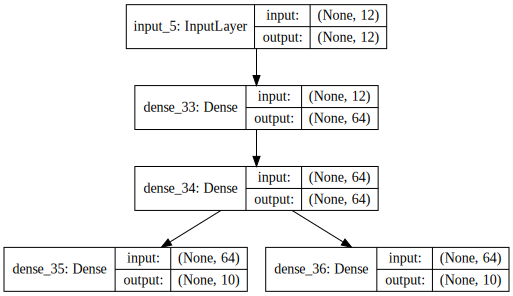

In [33]:
# a model like this isn't possible to create with the sequential api .. 
SVG(model_to_dot(model_f,show_shapes=True).create(prog='dot',format='svg'))

In [ ]:
# As aside, but we can still merge (for now!)

In [34]:
model_1=Sequential()
model_1.add(Dense(64,activation='relu',input_shape=(12,)))
model_1.add(Dense(64,activation='relu'))
model_1.add(Dense(10,activation='softmax'))

model_2=Sequential()
model_2.add(Dense(64,activation='relu',input_shape=(12,)))
model_2.add(Dense(64,activation='relu'))
model_2.add(Dense(10,activation='softmax'))

model_3=Sequential()
model_3.add(Merge([model_1,model_2]))

model_3.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# requires multiple inputs .. 
model_3.fit([X,X], [y],epochs=1) 

# oops looks like it's deprecated.. 

/Users/julialintern/anaconda/envs/ipython_env/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if sys.path[0] == '':


Epoch 1/1
100/100 [==============================] - 0s - loss: 2.5421 - acc: 0.1400     


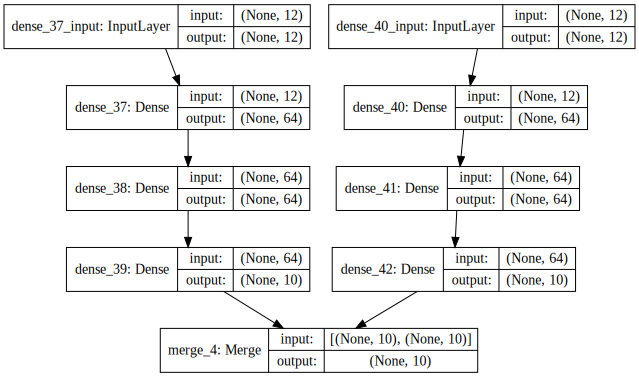

In [35]:
SVG(model_to_dot(model_3,show_shapes=True).create(prog='dot',format='svg'))

### Keras Functional API

1) Essentially, we can use the functional api to define any network that we can create 
with the Sequential, 

2) The following types of networks can only be defined using the functional api: 
- Models w/ multiples inputs and outputs
- Models composed of multiple submodels
- Models that use shared layers

3) Sequential() only stacks layers upon previous ones sequentially like a stack or queue, 
while with the Functional Api you can add any node to the space and connect them as you want. 


#### Functional Api  ~ multiple outputs  -- we can do this!


In [38]:

# A) we must define an input explicitly
## this will return a tensor
inputs=Input(shape=(12,),name='our_input')

# a layer Instance is callable on a tensor, and returns a tensor
x=Dense(64,activation='relu')(inputs)
x=Dense(64,activation='relu')(x)

predict1= Dense(10,activation='softmax')(x)
predict2= Dense(10,activation='softmax')(x)

#Input tensor(s) and output tensor(s) can then be used to define a Model
model_f= Model(inputs=inputs,outputs=[predict1,predict2])

#model_f.compile(optimizer='rmsprop',
              #loss='categorical_crossentropy',
              #metrics=['accuracy'])

# Our model can be trained just like a Sequential.. 
#model_f.fit(X,[y,y]) 

 The functional API makes it easy to work with multiple inputs and outputs
 

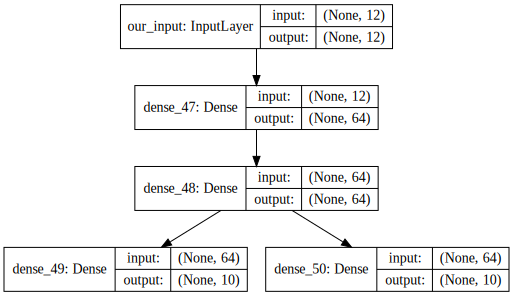

In [39]:
SVG(model_to_dot(model_f,show_shapes=True).create(prog='dot',format='svg'))

#### Functional Api  - Example 2

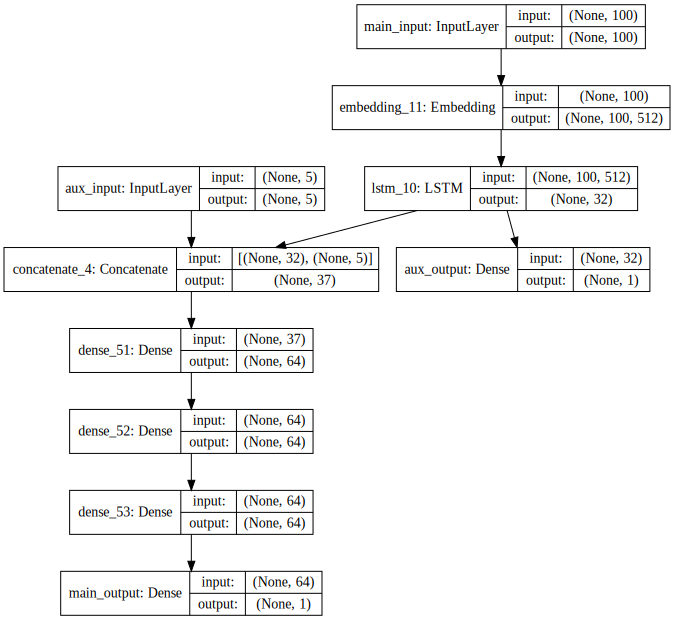

In [42]:
SVG(model_to_dot(model_f2,show_shapes=True).create(prog='dot',format='svg'))

In [45]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

# Headline input
main_input = Input(shape=(100,), dtype='int32', name='main_input')

# a layer Instance is callable on a tensor, and returns a tensor
x = Embedding(output_dim=512, input_dim=10000, input_length=100)(main_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32)(x)


auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)

# input - time of day and such,
auxiliary_input = Input(shape=(5,), name='aux_input')

# develop our left branch.. 
x = keras.layers.concatenate([lstm_out, auxiliary_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(1, activation='sigmoid', name='main_output')(x)

#Input tensor(s) and output tensor(s) can then be used to define a Model
model_f2 = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])

In [ ]:
# for last spring's passion project, which had an ideal implementation
# for Keras functional API.
# https://github.com/julialintern/fashionNet


#https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_DeepFashion_Powering_Robust_CVPR_2016_paper.pdf

### [FashionNet](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_DeepFashion_Powering_Robust_CVPR_2016_paper.pdf)

- Liu et al, Chinese University of Hong Kong
- 800 K images: annotated 
- FashionNet: learns clothing features by jointly predicting on attributes and landmarks. 


<img src='img/FN_architecture.png'>

FashionNet nutshell : 
 - Inputs: regional input (for this ex: upper body clothes)
 - Predictions :  attributes (ex: abstract floral print) , categories (top, dress..) , clothing landmarks, and landmark visibility
- Essentially the left lower branch is based off VGG 16.. we will modify the architecture from there.
     
     

<img src='img/landmarks.png'>
 
    

#### Perfect for the Functional API: 

- Multiple inputs and outputs
    - Each output has a specific loss function, metric & loss weights
- Shared Layers 

### Pose layer 

<img src='img/pose.png'>

**Step 1** Start by leveraging VGG16 ..

In [2]:
from keras.applications.vgg16 import VGG16

vgg16 = VGG16(weights='imagenet')

In [38]:
#SVG(model_to_dot(vgg16,show_shapes=True).create(prog='dot',format='svg'))

In [ ]:
# Freeze first 4 conv blocks.. 
for layer in vgg16.layers[:15]:
    layer.trainable = False

In [36]:
# grab output directly after last conv layer
conv = vgg16.get_layer('flatten').input   # theano.tensor.var.TensorVariable

In [5]:
# Again, lets call our layers on the tensors..
new = Dense(1024, activation='relu', name='fc6_pose')(convs)
new = Dense(1024, activation='relu', name='fc7_pose')(new)

# predict locations

# output : 6 visibility probabilities
vis1 = Dense(2, activation='softmax', name='visibility1')(new)  # visibility of left collar
vis2 = Dense(2, activation='softmax', name='visibility2')(new)  # .. 
vis3 = Dense(2, activation='softmax', name='visibility3')(new)  # vis. of left sleeve 
vis4 = Dense(2, activation='softmax', name='visibility4')(new)  
vis5 = Dense(2, activation='softmax', name='visibility5')(new)  # vis. of left hem.. 
vis6 = Dense(2, activation='softmax', name='visibility6')(new)

lm=Dense(12,activation='linear',name='landmarks')(new) # Landmarks : ~ x1, y1 of 6 landmarks 

/Users/julialintern/anaconda/envs/ipython_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_1, outputs=[Elemwise{...)`
  after removing the cwd from sys.path.


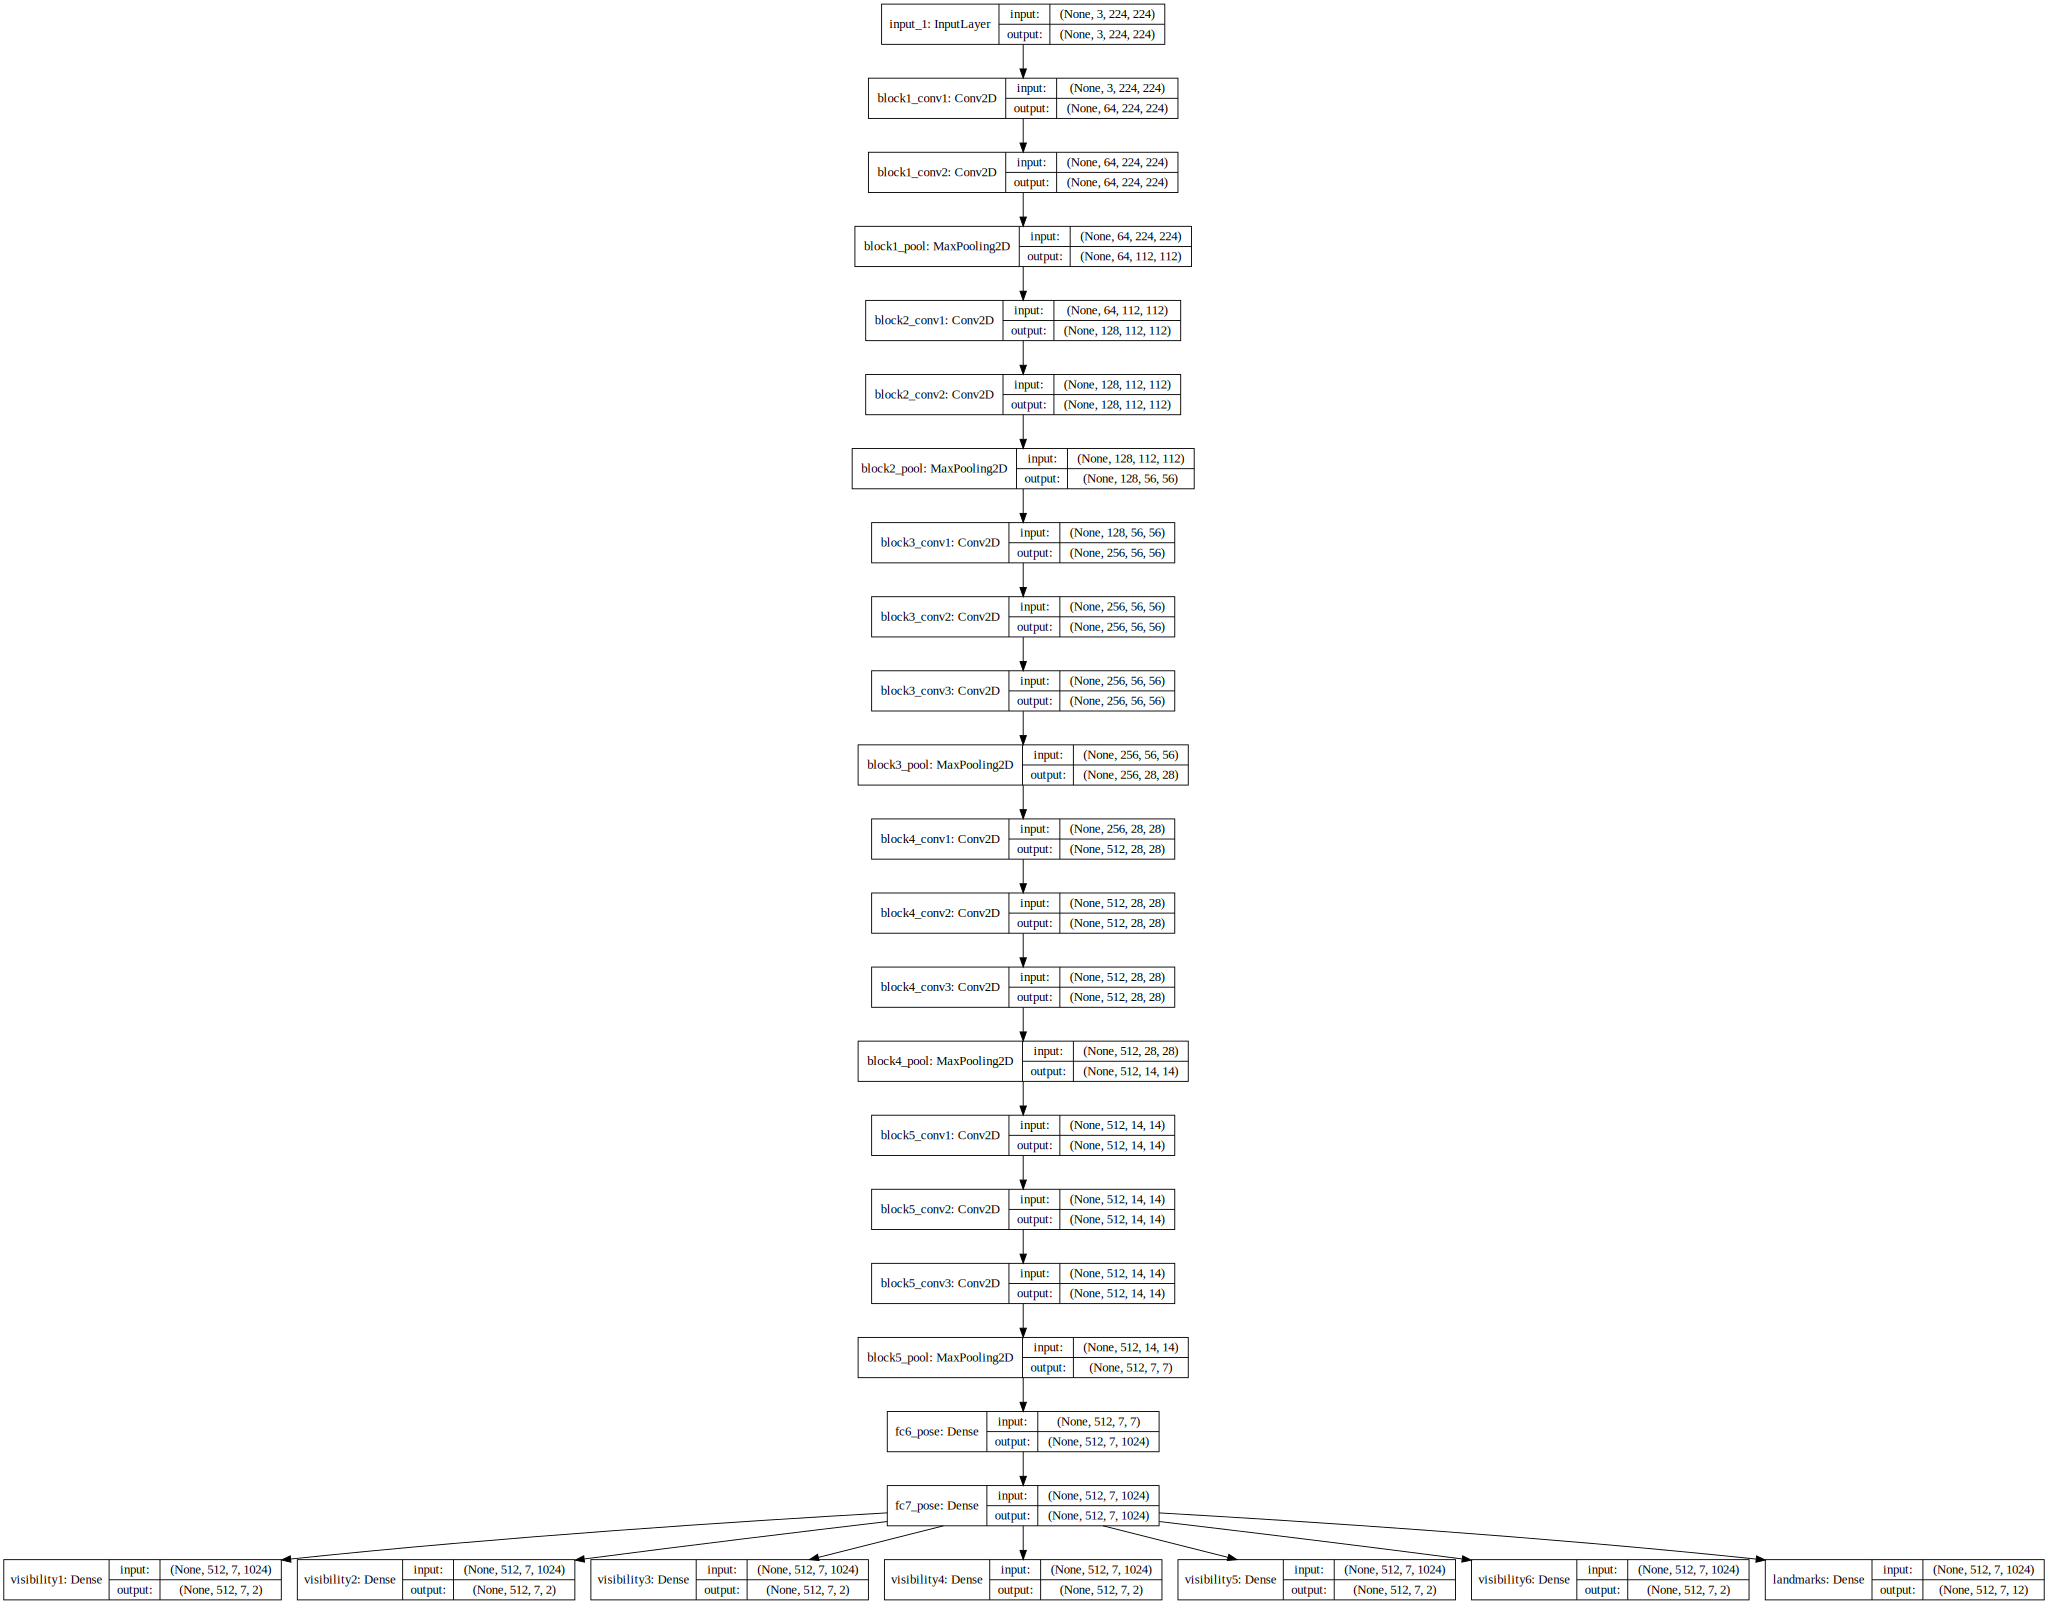

In [33]:
# sneak peek at our first layer: 

outputs=[vis1, vis2, vis3, vis4,vis5, vis6, lm]

#Input tensor(s) and output tensor(s) can then be used to define a Model
model = Model(inputs=vgg16.input, output=outputs)

SVG(model_to_dot(model,show_shapes=True).create(prog='dot',format='svg'))

### Local Layer

** Step 2**:  Develop the 2nd branch
Note: we have two inputs : Conv4 Output Features maps & Landmark predictions

A key component to FashionNet.  As shown, the inputs of the landmark pooling layers are 
feature maps &  estimated landmarks.  Recall that part of our mission for the first layer 
was to determine landmark visibility --> so we gate the responses of the invisible landmarks to zero.  

We want to grab the local features of the Conv feature maps.  I will use ROI pooling layer for this.  

We're not going to predict anything on this branch, it will just serve as input for our next branch. 

<img src='img/FN_architecture.png'>

In [39]:
# Grab another tensor 
conv4=vgg16.get_layer('block4_pool').input

In [ ]:
# Input for 2nd layer ~ ROI local features 

In [40]:
from keras import backend as K

In [41]:
# Gated Landmarks: landmarks are gated to zero if there is occlusion

# vizes=[vis1, vis2, vis3, vis4,vis5, vis6]

def gated_landmarks(lm,vizes):  # landmark & vis. predictions
    
    pred_lm=K.reshape(lm,(6,2))  
    vizes=K.reshape(vizes,(6,2))

    
    # if landmark is not visible, then gate to zero
    gates=K.argmax(vizes,axis=1)
    gated= K.dot(gates, pred_lm)
    gated=K.reshape(gated,(6,2))
    return gated


# function to change lm (6x2)~ (x,y)  to (6x4) ~(x,y,w,h)  where there are 6 landmarks
def get_rois(lm):
    
    pred_lm=K.reshape(lm,(6,2))
    # append w,h to lm array   ~ this will add a normalized window of about 20x 20 pixels 
    x=K.ones((6,2))/20
    pred_lm=K.concatenate((pred_lm,x),axis=1)  #  [.25,.2] -- > [.25,.2,.05,.05]
    pred_lm=K.reshape(pred_lm,(1,6,4))
    return pred_lm



In [42]:
# develop roi_input 
# https://github.com/yhenon/keras-frcnn/blob/master/keras_frcnn/RoiPoolingConv.py

from roi_pool import RoiPoolingConv

vizes=[vis1, vis2, vis3, vis4,vis5, vis6]

gated=gated_landmarks(lm,vizes)   # we can use our own function 
rois=Lambda(get_rois,output_shape=(None,6,4))(gated)    # or we can use function in conjunction with lambda layer
roi=RoiPoolingConv(2,6)([conv4,rois])   ## input list of two 4D tensors [conv4_feature,X_roi] 

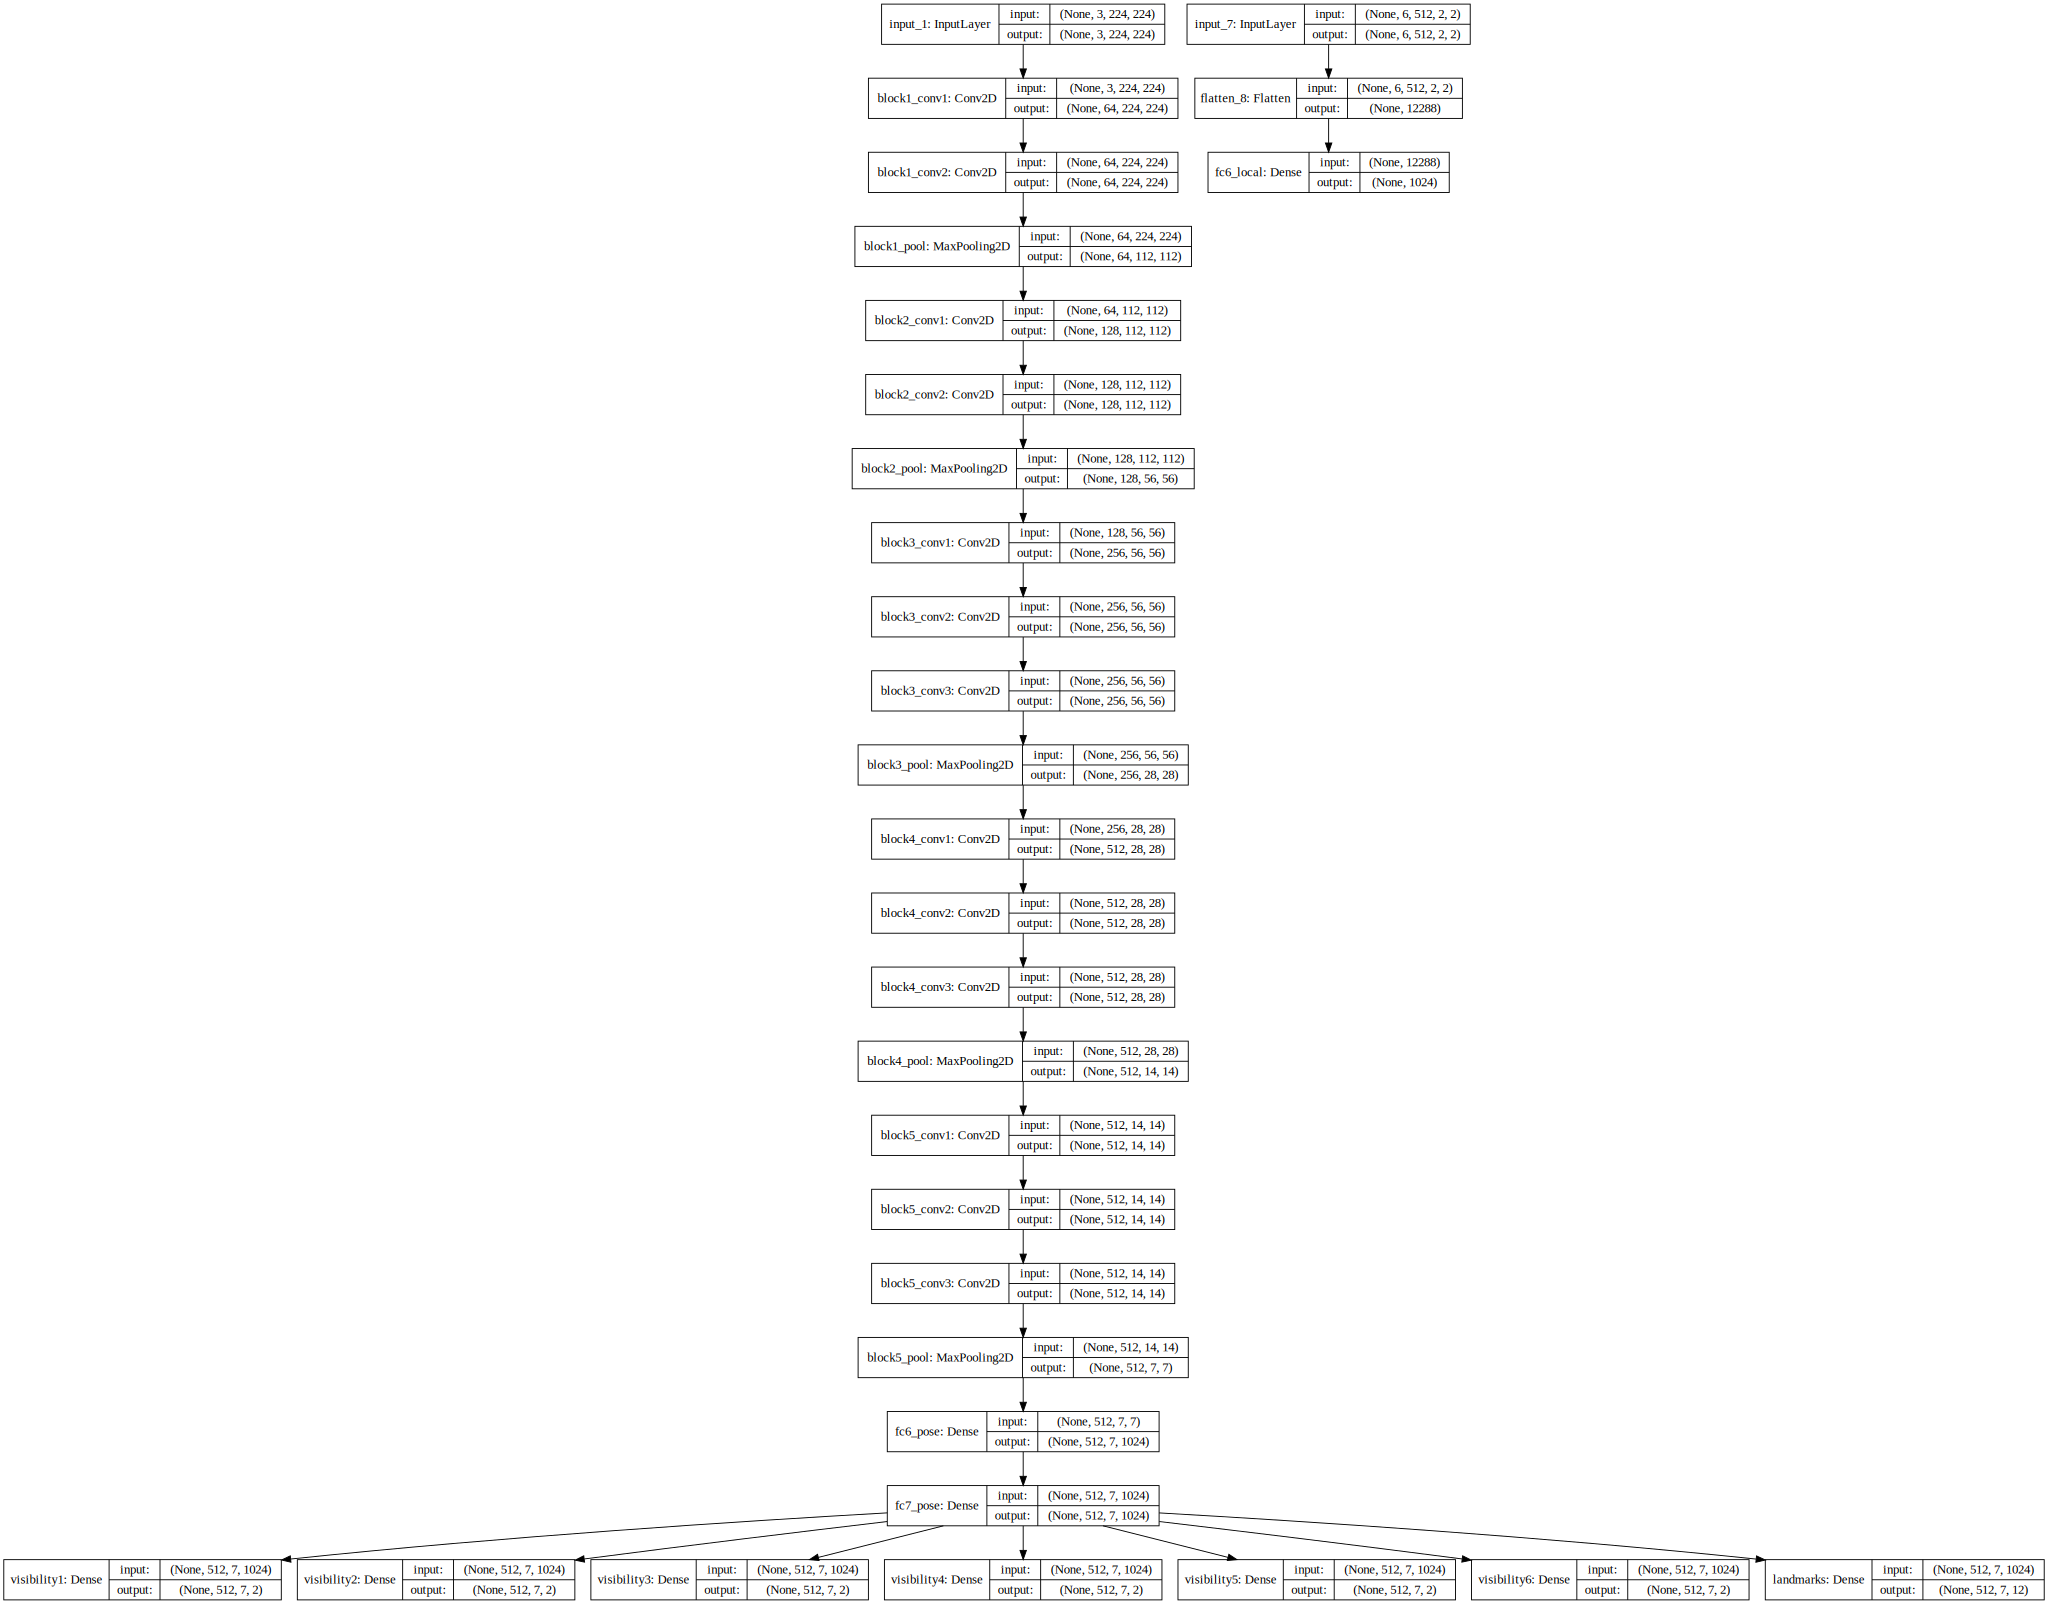

In [51]:
# define as an input tensor, 
# again, we'll need Input layers to a `Model` must be `InputLayer` objects.
roi=Input(tensor=roi)

#input_blue=vgg16.input

fc6_local=Flatten()(roi)
fc6_local = Dense(1024, activation='relu', name='fc6_local')(fc6_local)

outputs= [vis1, vis2, vis3, vis4,vis5, vis6, lm,fc6_local]
                                     
model=Model(inputs=[input_blue,roi],outputs=outputs)
SVG(model_to_dot(model,show_shapes=True).create(prog='dot',format='svg'))

In [45]:
#SVG(model_to_dot(model,show_shapes=True).create(prog='dot',format='svg'))

### Global Branch

<img src='img/FN_architecture.png'>

In [52]:
input_red= vgg16.get_layer('block4_pool').input

#input_red=Input(tensor=input_red)


# Develop last convolutional block
red = MaxPooling2D((2,2), strides=(2,2))(input_red)
red = ZeroPadding2D((1,1))(red)
red = Convolution2D(512, (3, 3), activation='relu')(red)
red = ZeroPadding2D((1,1))(red)
red = Convolution2D(512, (3, 3), activation='relu')(red)
red = ZeroPadding2D((1,1))(red)
red = Convolution2D(512, (3, 3), activation='relu')(red)
red =MaxPooling2D((2,2), strides=(2,2))(red)

red=Flatten()(red)
fc6_global = Dense(4096, activation='relu', name='fc6_global')(red)

# local features of “fc6 local” are concatenated together in “fc7 fusion”
fc7_fusion = keras.layers.concatenate([fc6_local,fc6_global])

In [53]:
atts=Dense(1000,activation='softmax',name='attributes')(fc7_fusion)
cat=Dense(50,activation='softmax',name='categories')(fc7_fusion)

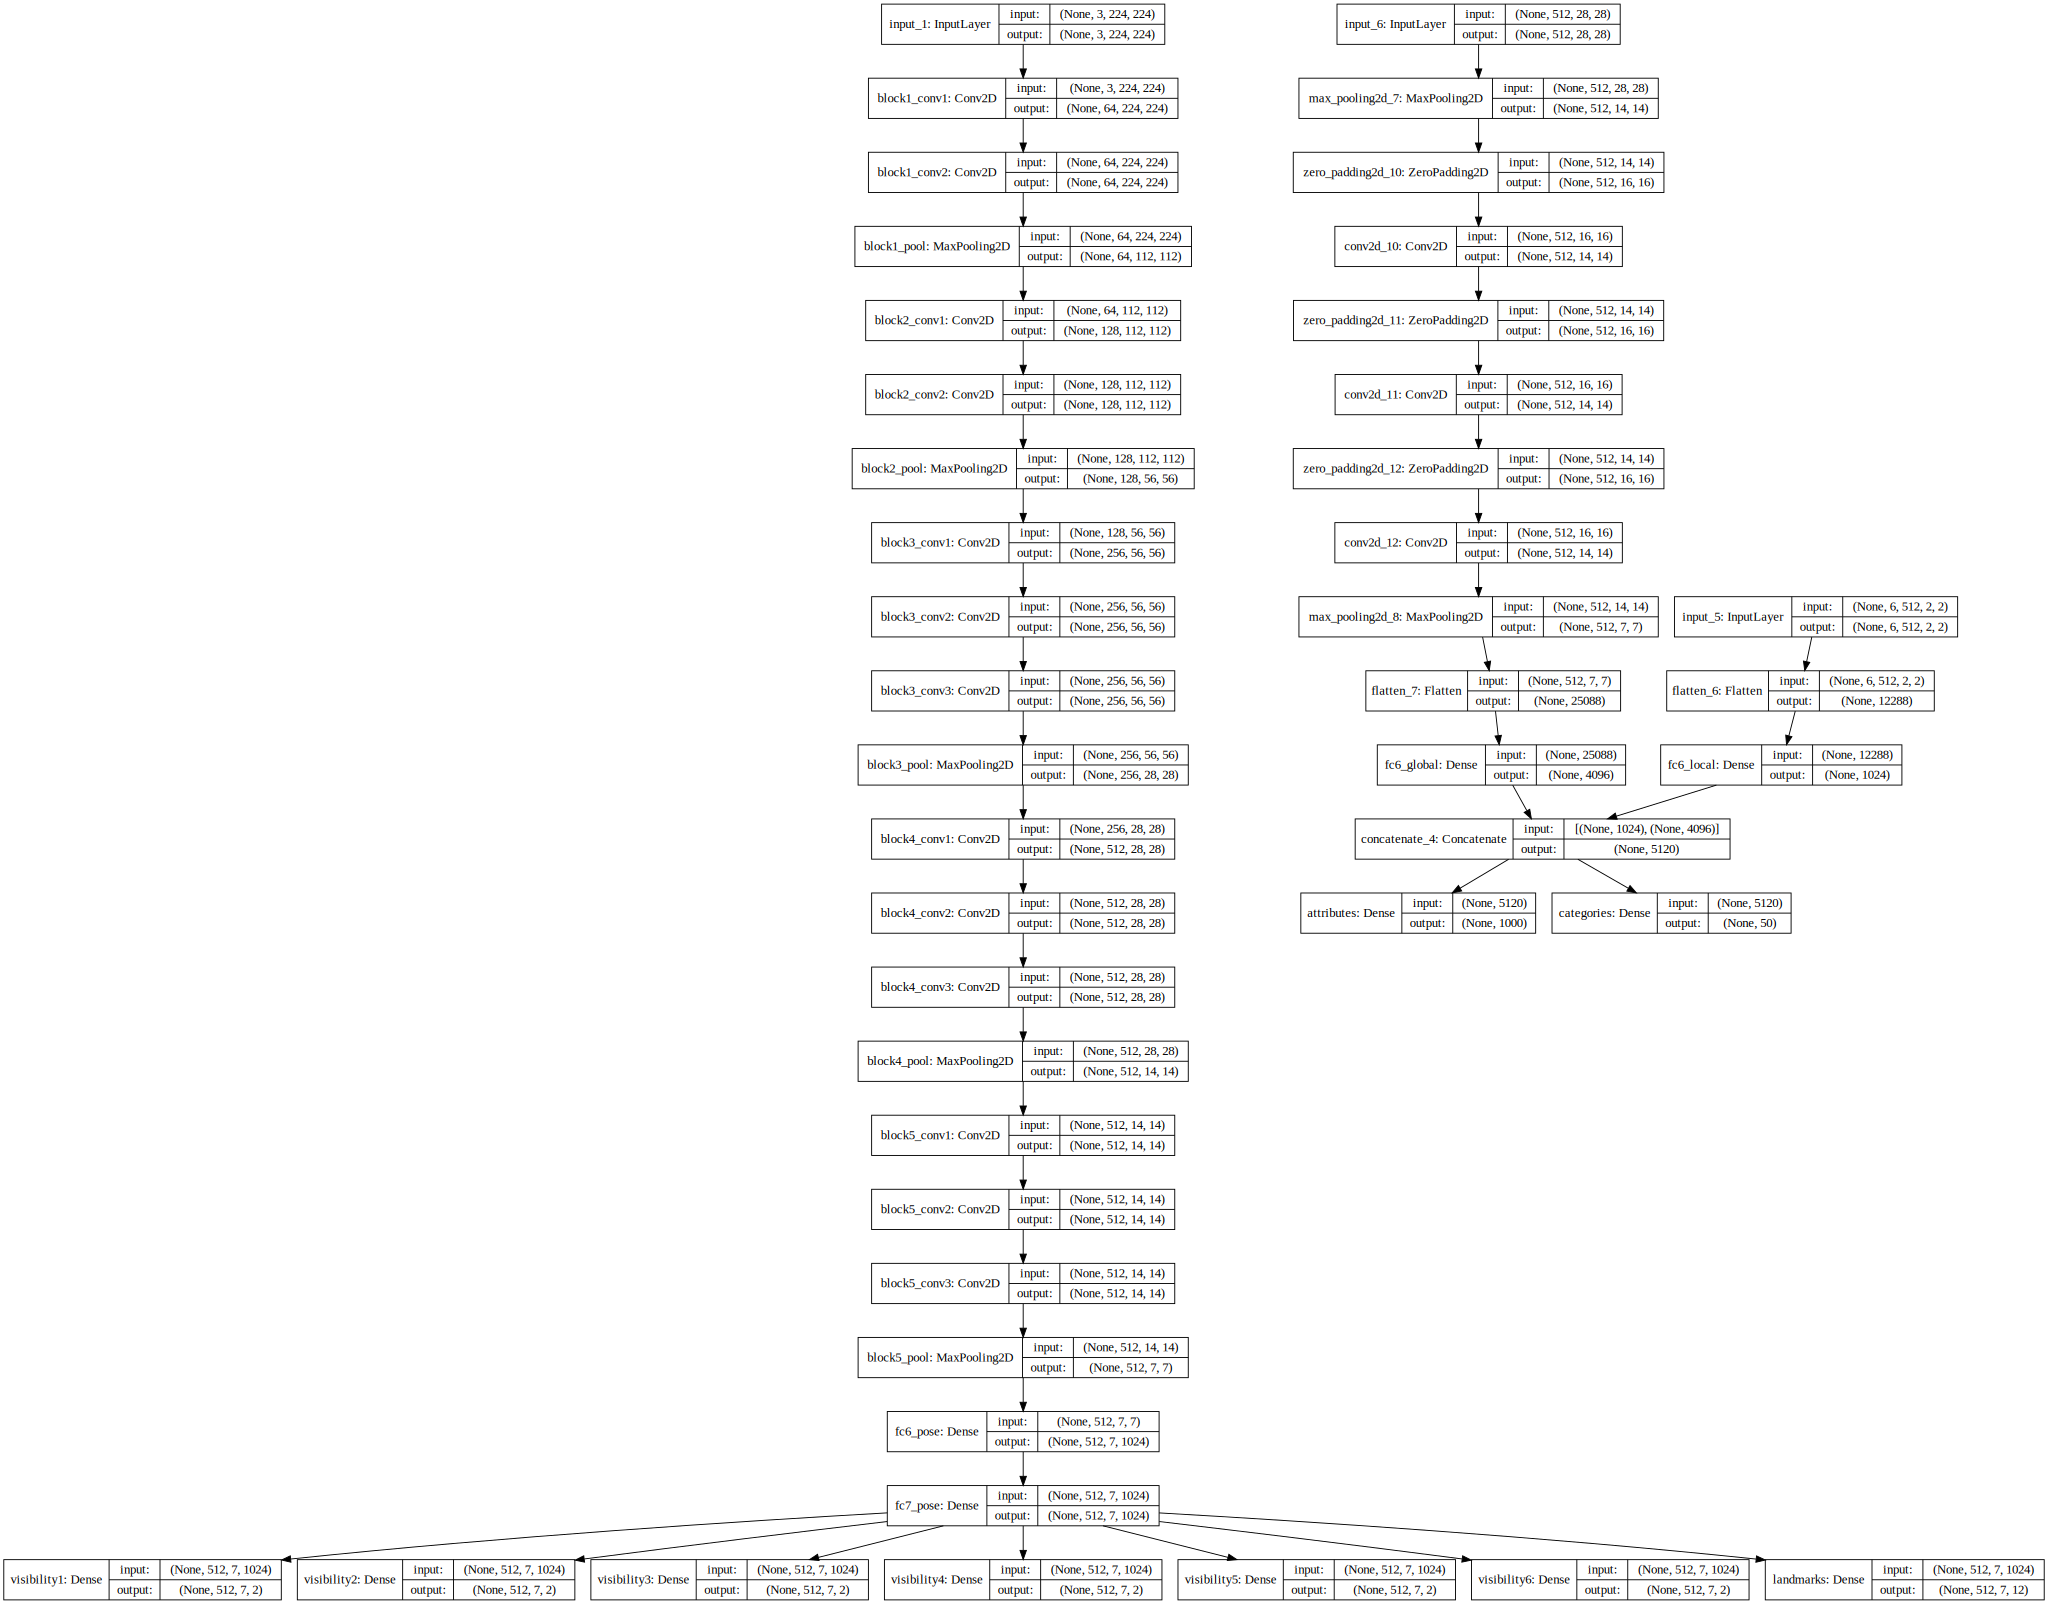

In [48]:
outputs= [vis1, vis2, vis3, vis4,vis5, vis6, lm,atts,cat]

model=Model(inputs=[input_blue,roi,input_red],outputs=outputs)

SVG(model_to_dot(model,show_shapes=True).create(prog='dot',format='svg'))

### Some other cool bits: 

In [ ]:
# We can make our own custom loss function 


def custom_objective(y_true, y_pred):
    '''tailored cost function'''

    pred_lm=y_pred[6]  
    true_lm=y_true[6]  #get landmarks
    
    pred_lm=K.reshape(pred_lm,(4,2))
    true_lm=K.reshape(true_lm,(4,2))

    # get visibility binaries
    true_viz=y_true[:6]
    
    # predict if visible or not, if not visible, set landmark loss to zero
    wins=K.argmax(true_viz,axis=1)
    
    #shapes : wins: (1,6), pred_lm: 6,2
    loss=K.mean(K.square(K.dot(wins,(pred_lm-true_lm))))  
    return loss

In [ ]:
# Assign specific loss functions, metrics & weights to specific outputs.. 

from keras.optimizers import SGD, Adam

losses={'visibility1':'binary_crossentropy','visibility2':'binary_crossentropy','visibility3':'binary_crossentropy',
        'visibility4':'binary_crossentropy','visibility5':'binary_crossentropy',
'visibility6':'binary_crossentropy', 'landmarks':custom_objective}

my_metrics={'visibility1':single_class_accuracy(0),'visibility2':single_class_accuracy(0),'visibility3':single_class_accuracy(0),
        'visibility4':single_class_accuracy(0),'visibility5':single_class_accuracy(0),
'visibility6':single_class_accuracy(0),'landmarks':'mean_squared_error'}

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss=losses,optimizer=adam,metrics=my_metrics)

